In [1]:
# to monitor the progress
from tqdm import tqdm
import time
# basic dependency
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Class for client
class client_base:
    def __init__(self, client_requirement=[0,0,0]):
        self.requirement = client_requirement
              
    def compute_fee(self, p1, p2, p3, t1, t2, n):
        fee = 0
        if 0 < n <= t1:
            fee = p1*n
        elif t1 < n <= t2:
            fee = p1*t1+p2*(n-t1)
        elif t2 < n :
            fee = p1*t1+p2*(t2-t1)+p3*(n-t2)
        else:
            print('Out of Range!')
            return -1
        return fee
    
    def compute_avg_price(self, fee, num):
        if num==0:
            print(num)
        return fee/num
    
    def compute_total_fee(self, f1, f2, f3):
        return f1+f2+f3
    
    def related_fee(self, client_requirement = None):
        
        if client_requirement == None:
            client_requirement = self.requirement
        if client_requirement[0] == 0 or client_requirement[1] == 0 or client_requirement[2] == 0:
            print('Some zeros appear!')
            print(client_requirement)     
        vcpu_fee_r = self.compute_fee(0.2,0.1,0.05,10,30,client_requirement[0])
        vcpu_avg_r = self.compute_avg_price(vcpu_fee_r,client_requirement[0])
        ram_fee_r = self.compute_fee(0.1,0.05,0.025,20,60,client_requirement[1])
        ram_avg_r = self.compute_avg_price(ram_fee_r,client_requirement[1])
        volume_fee_r = self.compute_fee(0.02,0.01,0.005,100,300,client_requirement[2])
        volume_avg_r = self.compute_avg_price(volume_fee_r,client_requirement[2])
        total_fee_r = vcpu_fee_r+ram_fee_r+volume_fee_r
        return vcpu_avg_r,ram_avg_r,volume_avg_r,total_fee_r

In [3]:
client = client_base()
def compute_total_fee(x1,x2,x3):
    offer = (x1,x2,x3)
    _,_,_,total_fee_new = client.related_fee(offer)
    return total_fee_new

# X

In [4]:
df_x_test = pd.read_csv('./data/offer_ML/x_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_x_test['requirement_total_fee'] = df_x_test.apply(lambda x: compute_total_fee(x['vcpu'],x['ram'],x['volume']), axis=1)
x_fee_array = np.array(df_x_test['requirement_total_fee'].tolist())

In [5]:
df_x_test

,vcpu,ram,volume,requirement_total_fee
0,5,25,400,7.750
1,7,35,220,7.350
2,7,54,400,9.600
3,7,56,320,9.300
4,7,56,520,10.300
...,...,...,...,...
195,47,122,660,16.200
196,47,138,700,16.800
197,47,164,720,17.550
198,48,111,820,16.775


In [6]:
x_vcpu_array = np.array(df_x_test['vcpu'].tolist())
x_ram_array = np.array(df_x_test['ram'].tolist())
x_storage_array = np.array(df_x_test['volume'].tolist())

In [7]:
df_x_test[190:200]

,vcpu,ram,volume,requirement_total_fee
190,44,159,470,16.025
191,45,97,730,15.825
192,45,129,660,16.275
193,45,131,860,17.325
194,46,156,840,17.900
195,47,122,660,16.200
196,47,138,700,16.800
197,47,164,720,17.550
198,48,111,820,16.775
199,48,144,690,16.950


# Different versions

In [8]:
# Normalization function
vcpu_scaler = lambda x : (x-1)/(90-1)
ram_scaler = lambda x : (x-1)/(180-1)
volume_scaler = lambda x : (x-1)/(900-1)

## v4

In [9]:
df_v4_y_test = pd.read_csv('./data/offer_ML/v4_y_test_200_v1_p5.csv',index_col=0).reset_index(drop=True)
df_v4_y_test_predict = pd.read_csv('./data/offer_ML/v4_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v4_y_test['label_total_fee'] = df_v4_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v4_y_test_predict['predict_total_fee'] = df_v4_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v4_label_fee_array = np.array(df_v4_y_test['label_total_fee'].tolist())
v4_predict_fee_array = np.array(df_v4_y_test_predict['predict_total_fee'].tolist())

v4_label_fee_ratio_array = v4_label_fee_array/x_fee_array
v4_predict_fee_ratio_array = v4_predict_fee_array/x_fee_array

In [10]:
v4_label_vcpu_array = np.array(df_v4_y_test['final_vcpu'].tolist())
v4_label_ram_array = np.array(df_v4_y_test['final_ram'].tolist())
v4_label_storage_array = np.array(df_v4_y_test['final_volume'].tolist())

v4_label_vcpu_ratio = v4_label_vcpu_array/x_vcpu_array 
v4_label_ram_ratio = v4_label_ram_array/x_ram_array
v4_label_storage_ratio = v4_label_storage_array/x_storage_array

v4_predict_vcpu_array = np.array(df_v4_y_test_predict['predict_vcpu'].tolist())
v4_predict_ram_array = np.array(df_v4_y_test_predict['predict_ram'].tolist())
v4_predict_storage_array = np.array(df_v4_y_test_predict['predict_volume'].tolist())

v4_predict_vcpu_ratio = v4_predict_vcpu_array/x_vcpu_array 
v4_predict_ram_ratio = v4_predict_ram_array/x_ram_array
v4_predict_storage_ratio = v4_predict_storage_array/x_storage_array

In [11]:
new_df_v4_y_test = pd.DataFrame(df_v4_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v4_y_test_predict = pd.DataFrame(df_v4_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v4_y_test[['final_vcpu']] = new_df_v4_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v4_y_test[['final_ram']] = new_df_v4_y_test[['final_ram']].apply(ram_scaler)
new_df_v4_y_test[['final_volume']] = new_df_v4_y_test[['final_volume']].apply(volume_scaler)

new_df_v4_y_test_predict[['predict_vcpu']] = new_df_v4_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v4_y_test_predict[['predict_ram']] = new_df_v4_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v4_y_test_predict[['predict_volume']] = new_df_v4_y_test_predict[['predict_volume']].apply(volume_scaler)

v4_label = (torch.tensor(new_df_v4_y_test.values)).float()
v4_predict = (torch.tensor(new_df_v4_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v4_label,v4_predict)

tensor(0.0015)

## v3

In [12]:
df_v3_y_test = pd.read_csv('./data/offer_ML/v4_y_test_200_v1_p15.csv',index_col=0).reset_index(drop=True)
df_v3_y_test_predict = pd.read_csv('./data/offer_ML/v3_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)
df_v3_y_test_predict1 = pd.read_csv('./data/offer_ML/v3_predict_test_200_train_104_v1_6layer.csv',index_col=0).reset_index(drop=True)
df_v3_y_test_predict2 = pd.read_csv('./data/offer_ML/v3_predict_test_200_train_104_v1_4layer.csv',index_col=0).reset_index(drop=True)
df_v3_y_test_predict3 = pd.read_csv('./data/offer_ML/v3_predict_test_200_train_104_v1_7layer.csv',index_col=0).reset_index(drop=True)

df_v3_y_test['label_total_fee'] = df_v3_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v3_y_test_predict['predict_total_fee'] = df_v3_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)
df_v3_y_test_predict1['predict_total_fee'] = df_v3_y_test_predict1.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)
df_v3_y_test_predict2['predict_total_fee'] = df_v3_y_test_predict2.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)
df_v3_y_test_predict3['predict_total_fee'] = df_v3_y_test_predict3.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)


v3_label_fee_array = np.array(df_v3_y_test['label_total_fee'].tolist())
v3_predict_fee_array = np.array(df_v3_y_test_predict['predict_total_fee'].tolist())
v3_predict_fee_array1 = np.array(df_v3_y_test_predict1['predict_total_fee'].tolist())
v3_predict_fee_array2 = np.array(df_v3_y_test_predict2['predict_total_fee'].tolist())
v3_predict_fee_array3 = np.array(df_v3_y_test_predict3['predict_total_fee'].tolist())


v3_label_fee_ratio_array = v3_label_fee_array/x_fee_array
v3_predict_fee_ratio_array = v3_predict_fee_array/x_fee_array
v3_predict_fee_ratio_array1 = v3_predict_fee_array1/x_fee_array
v3_predict_fee_ratio_array2 = v3_predict_fee_array2/x_fee_array
v3_predict_fee_ratio_array3 = v3_predict_fee_array3/x_fee_array

In [13]:
v3_label_vcpu_array = np.array(df_v3_y_test['final_vcpu'].tolist())
v3_label_ram_array = np.array(df_v3_y_test['final_ram'].tolist())
v3_label_storage_array = np.array(df_v3_y_test['final_volume'].tolist())

v3_label_vcpu_ratio = v3_label_vcpu_array/x_vcpu_array 
v3_label_ram_ratio = v3_label_ram_array/x_ram_array
v3_label_storage_ratio = v3_label_storage_array/x_storage_array

v3_predict_vcpu_array = np.array(df_v3_y_test_predict['predict_vcpu'].tolist())
v3_predict_ram_array = np.array(df_v3_y_test_predict['predict_ram'].tolist())
v3_predict_storage_array = np.array(df_v3_y_test_predict['predict_volume'].tolist())

v3_predict_vcpu_ratio = v3_predict_vcpu_array/x_vcpu_array 
v3_predict_ram_ratio = v3_predict_ram_array/x_ram_array
v3_predict_storage_ratio = v3_predict_storage_array/x_storage_array

v3_predict1_vcpu_array = np.array(df_v3_y_test_predict1['predict_vcpu'].tolist())
v3_predict1_ram_array = np.array(df_v3_y_test_predict1['predict_ram'].tolist())
v3_predict1_storage_array = np.array(df_v3_y_test_predict1['predict_volume'].tolist())

v3_predict1_vcpu_ratio = v3_predict1_vcpu_array/x_vcpu_array 
v3_predict1_ram_ratio = v3_predict1_ram_array/x_ram_array
v3_predict1_storage_ratio = v3_predict1_storage_array/x_storage_array

v3_predict2_vcpu_array = np.array(df_v3_y_test_predict2['predict_vcpu'].tolist())
v3_predict2_ram_array = np.array(df_v3_y_test_predict2['predict_ram'].tolist())
v3_predict2_storage_array = np.array(df_v3_y_test_predict2['predict_volume'].tolist())

v3_predict2_vcpu_ratio = v3_predict2_vcpu_array/x_vcpu_array 
v3_predict2_ram_ratio = v3_predict2_ram_array/x_ram_array
v3_predict2_storage_ratio = v3_predict2_storage_array/x_storage_array

v3_predict3_vcpu_array = np.array(df_v3_y_test_predict3['predict_vcpu'].tolist())
v3_predict3_ram_array = np.array(df_v3_y_test_predict3['predict_ram'].tolist())
v3_predict3_storage_array = np.array(df_v3_y_test_predict3['predict_volume'].tolist())

v3_predict3_vcpu_ratio = v3_predict3_vcpu_array/x_vcpu_array 
v3_predict3_ram_ratio = v3_predict3_ram_array/x_ram_array
v3_predict3_storage_ratio = v3_predict3_storage_array/x_storage_array

In [14]:
new_df_v3_y_test = pd.DataFrame(df_v3_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v3_y_test_predict = pd.DataFrame(df_v3_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])
new_df_v3_y_test_predict1 = pd.DataFrame(df_v3_y_test_predict1, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])
new_df_v3_y_test_predict2 = pd.DataFrame(df_v3_y_test_predict2, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])
new_df_v3_y_test_predict3 = pd.DataFrame(df_v3_y_test_predict3, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v3_y_test[['final_vcpu']] = new_df_v3_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v3_y_test[['final_ram']] = new_df_v3_y_test[['final_ram']].apply(ram_scaler)
new_df_v3_y_test[['final_volume']] = new_df_v3_y_test[['final_volume']].apply(volume_scaler)

new_df_v3_y_test_predict[['predict_vcpu']] = new_df_v3_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v3_y_test_predict[['predict_ram']] = new_df_v3_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v3_y_test_predict[['predict_volume']] = new_df_v3_y_test_predict[['predict_volume']].apply(volume_scaler)

new_df_v3_y_test_predict1[['predict_vcpu']] = new_df_v3_y_test_predict1[['predict_vcpu']].apply(vcpu_scaler)
new_df_v3_y_test_predict1[['predict_ram']] = new_df_v3_y_test_predict1[['predict_ram']].apply(ram_scaler)
new_df_v3_y_test_predict1[['predict_volume']] = new_df_v3_y_test_predict1[['predict_volume']].apply(volume_scaler)

new_df_v3_y_test_predict2[['predict_vcpu']] = new_df_v3_y_test_predict2[['predict_vcpu']].apply(vcpu_scaler)
new_df_v3_y_test_predict2[['predict_ram']] = new_df_v3_y_test_predict2[['predict_ram']].apply(ram_scaler)
new_df_v3_y_test_predict2[['predict_volume']] = new_df_v3_y_test_predict2[['predict_volume']].apply(volume_scaler)

new_df_v3_y_test_predict3[['predict_vcpu']] = new_df_v3_y_test_predict3[['predict_vcpu']].apply(vcpu_scaler)
new_df_v3_y_test_predict3[['predict_ram']] = new_df_v3_y_test_predict3[['predict_ram']].apply(ram_scaler)
new_df_v3_y_test_predict3[['predict_volume']] = new_df_v3_y_test_predict3[['predict_volume']].apply(volume_scaler)

v3_label = (torch.tensor(new_df_v3_y_test.values)).float()
v3_predict = (torch.tensor(new_df_v3_y_test_predict.values)).float()
v3_predict1 = (torch.tensor(new_df_v3_y_test_predict1.values)).float()
v3_predict2 = (torch.tensor(new_df_v3_y_test_predict2.values)).float()
v3_predict3 = (torch.tensor(new_df_v3_y_test_predict3.values)).float()
criterion = nn.MSELoss()
print('deepnn',criterion(v3_label,v3_predict))
print('6layer',criterion(v3_label,v3_predict1))
print('4layer',criterion(v3_label,v3_predict2))
print('7layer',criterion(v3_label,v3_predict3))

deepnn tensor(0.0011)
6layer tensor(0.0090)
4layer tensor(0.0092)
7layer tensor(0.0090)


In [15]:
print('VCPU')
print('deepnn',criterion(v3_label[:,0],v3_predict[:,0]))
print('6layer',criterion(v3_label[:,0],v3_predict1[:,0]))
print('4layer',criterion(v3_label[:,0],v3_predict2[:,0]))
print('7layer',criterion(v3_label[:,0],v3_predict3[:,0]))

VCPU
deepnn tensor(0.0018)
6layer tensor(0.0155)
4layer tensor(0.0159)
7layer tensor(0.0157)


In [16]:
print('RAM')
print('deepnn',criterion(v3_label[:,1],v3_predict[:,1]))
print('6layer',criterion(v3_label[:,1],v3_predict1[:,1]))
print('4layer',criterion(v3_label[:,1],v3_predict2[:,1]))
print('7layer',criterion(v3_label[:,1],v3_predict3[:,1]))

RAM
deepnn tensor(0.0009)
6layer tensor(0.0057)
4layer tensor(0.0055)
7layer tensor(0.0055)


In [17]:
print('Storage')
print('deepnn',criterion(v3_label[:,2],v3_predict[:,2]))
print('6layer',criterion(v3_label[:,2],v3_predict1[:,2]))
print('4layer',criterion(v3_label[:,2],v3_predict2[:,2]))
print('7layer',criterion(v3_label[:,2],v3_predict3[:,2]))

Storage
deepnn tensor(0.0005)
6layer tensor(0.0057)
4layer tensor(0.0060)
7layer tensor(0.0057)


In [18]:
v3_label[0,:]

tensor([0.0787, 0.2458, 0.4438])

## v2

In [19]:
df_v2_y_test = pd.read_csv('./data/offer_ML/v4_y_test_200_v1_p11.csv',index_col=0).reset_index(drop=True)
df_v2_y_test_predict = pd.read_csv('./data/offer_ML/v2_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v2_y_test['label_total_fee'] = df_v2_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v2_y_test_predict['predict_total_fee'] = df_v2_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v2_label_fee_array = np.array(df_v2_y_test['label_total_fee'].tolist())
v2_predict_fee_array = np.array(df_v2_y_test_predict['predict_total_fee'].tolist())

v2_label_fee_ratio_array = v2_label_fee_array/x_fee_array
v2_predict_fee_ratio_array = v2_predict_fee_array/x_fee_array

In [20]:
v2_label_vcpu_array = np.array(df_v2_y_test['final_vcpu'].tolist())
v2_label_ram_array = np.array(df_v2_y_test['final_ram'].tolist())
v2_label_storage_array = np.array(df_v2_y_test['final_volume'].tolist())

v2_label_vcpu_ratio = v2_label_vcpu_array/x_vcpu_array 
v2_label_ram_ratio = v2_label_ram_array/x_ram_array
v2_label_storage_ratio = v2_label_storage_array/x_storage_array

v2_predict_vcpu_array = np.array(df_v2_y_test_predict['predict_vcpu'].tolist())
v2_predict_ram_array = np.array(df_v2_y_test_predict['predict_ram'].tolist())
v2_predict_storage_array = np.array(df_v2_y_test_predict['predict_volume'].tolist())

v2_predict_vcpu_ratio = v2_predict_vcpu_array/x_vcpu_array 
v2_predict_ram_ratio = v2_predict_ram_array/x_ram_array
v2_predict_storage_ratio = v2_predict_storage_array/x_storage_array

In [21]:
new_df_v2_y_test = pd.DataFrame(df_v2_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v2_y_test_predict = pd.DataFrame(df_v2_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v2_y_test[['final_vcpu']] = new_df_v2_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v2_y_test[['final_ram']] = new_df_v2_y_test[['final_ram']].apply(ram_scaler)
new_df_v2_y_test[['final_volume']] = new_df_v2_y_test[['final_volume']].apply(volume_scaler)

new_df_v2_y_test_predict[['predict_vcpu']] = new_df_v2_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v2_y_test_predict[['predict_ram']] = new_df_v2_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v2_y_test_predict[['predict_volume']] = new_df_v2_y_test_predict[['predict_volume']].apply(volume_scaler)

v2_label = (torch.tensor(new_df_v2_y_test.values)).float()
v2_predict = (torch.tensor(new_df_v2_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v2_label,v2_predict)

tensor(0.0020)

## v1

In [22]:
df_v1_y_test = pd.read_csv('./data/offer_ML/v4_y_test_200_v1_p1.csv',index_col=0).reset_index(drop=True)
df_v1_y_test_predict = pd.read_csv('./data/offer_ML/v1_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v1_y_test['label_total_fee'] = df_v1_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v1_y_test_predict['predict_total_fee'] = df_v1_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v1_label_fee_array = np.array(df_v1_y_test['label_total_fee'].tolist())
v1_predict_fee_array = np.array(df_v1_y_test_predict['predict_total_fee'].tolist())

v1_label_fee_ratio_array = v1_label_fee_array/x_fee_array
v1_predict_fee_ratio_array = v1_predict_fee_array/x_fee_array

In [23]:
v1_label_vcpu_array = np.array(df_v1_y_test['final_vcpu'].tolist())
v1_label_ram_array = np.array(df_v1_y_test['final_ram'].tolist())
v1_label_storage_array = np.array(df_v1_y_test['final_volume'].tolist())

v1_label_vcpu_ratio = v1_label_vcpu_array/x_vcpu_array 
v1_label_ram_ratio = v1_label_ram_array/x_ram_array
v1_label_storage_ratio = v1_label_storage_array/x_storage_array

v1_predict_vcpu_array = np.array(df_v1_y_test_predict['predict_vcpu'].tolist())
v1_predict_ram_array = np.array(df_v1_y_test_predict['predict_ram'].tolist())
v1_predict_storage_array = np.array(df_v1_y_test_predict['predict_volume'].tolist())

v1_predict_vcpu_ratio = v1_predict_vcpu_array/x_vcpu_array 
v1_predict_ram_ratio = v1_predict_ram_array/x_ram_array
v1_predict_storage_ratio = v1_predict_storage_array/x_storage_array

In [24]:
new_df_v1_y_test = pd.DataFrame(df_v1_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v1_y_test_predict = pd.DataFrame(df_v1_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v1_y_test[['final_vcpu']] = new_df_v1_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v1_y_test[['final_ram']] = new_df_v1_y_test[['final_ram']].apply(ram_scaler)
new_df_v1_y_test[['final_volume']] = new_df_v1_y_test[['final_volume']].apply(volume_scaler)

new_df_v1_y_test_predict[['predict_vcpu']] = new_df_v1_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v1_y_test_predict[['predict_ram']] = new_df_v1_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v1_y_test_predict[['predict_volume']] = new_df_v1_y_test_predict[['predict_volume']].apply(volume_scaler)

v1_label = (torch.tensor(new_df_v1_y_test.values)).float()
v1_predict = (torch.tensor(new_df_v1_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v1_label,v1_predict)

tensor(0.0026)

## v0

In [25]:
df_v0_y_test = pd.read_csv('./data/offer_ML/v0_y_test_200_v1.csv',index_col=0).reset_index(drop=True)
df_v0_y_test_predict = pd.read_csv('./data/offer_ML/v0_predict_test_200_train_104_v1_deepNN.csv',index_col=0).reset_index(drop=True)

df_v0_y_test['label_total_fee'] = df_v0_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)
df_v0_y_test_predict['predict_total_fee'] = df_v0_y_test_predict.apply(lambda x: compute_total_fee(x['predict_vcpu'],x['predict_ram'],x['predict_volume']), axis=1)

v0_label_fee_array = np.array(df_v0_y_test['label_total_fee'].tolist())
v0_predict_fee_array = np.array(df_v0_y_test_predict['predict_total_fee'].tolist())

v0_label_fee_ratio_array = v0_label_fee_array/x_fee_array
v0_predict_fee_ratio_array = v0_predict_fee_array/x_fee_array

In [26]:
v0_label_vcpu_array = np.array(df_v0_y_test['final_vcpu'].tolist())
v0_label_ram_array = np.array(df_v0_y_test['final_ram'].tolist())
v0_label_storage_array = np.array(df_v0_y_test['final_volume'].tolist())

v0_label_vcpu_ratio = v0_label_vcpu_array/x_vcpu_array 
v0_label_ram_ratio = v0_label_ram_array/x_ram_array
v0_label_storage_ratio = v0_label_storage_array/x_storage_array

v0_predict_vcpu_array = np.array(df_v0_y_test_predict['predict_vcpu'].tolist())
v0_predict_ram_array = np.array(df_v0_y_test_predict['predict_ram'].tolist())
v0_predict_storage_array = np.array(df_v0_y_test_predict['predict_volume'].tolist())

v0_predict_vcpu_ratio = v0_predict_vcpu_array/x_vcpu_array 
v0_predict_ram_ratio = v0_predict_ram_array/x_ram_array
v0_predict_storage_ratio = v0_predict_storage_array/x_storage_array

In [27]:
new_df_v0_y_test = pd.DataFrame(df_v0_y_test, columns=['final_vcpu', 'final_ram', 'final_volume'])
new_df_v0_y_test_predict = pd.DataFrame(df_v0_y_test_predict, columns=['predict_vcpu', 'predict_ram', 'predict_volume'])

new_df_v0_y_test[['final_vcpu']] = new_df_v0_y_test[['final_vcpu']].apply(vcpu_scaler)
new_df_v0_y_test[['final_ram']] = new_df_v0_y_test[['final_ram']].apply(ram_scaler)
new_df_v0_y_test[['final_volume']] = new_df_v0_y_test[['final_volume']].apply(volume_scaler)

new_df_v0_y_test_predict[['predict_vcpu']] = new_df_v0_y_test_predict[['predict_vcpu']].apply(vcpu_scaler)
new_df_v0_y_test_predict[['predict_ram']] = new_df_v0_y_test_predict[['predict_ram']].apply(ram_scaler)
new_df_v0_y_test_predict[['predict_volume']] = new_df_v0_y_test_predict[['predict_volume']].apply(volume_scaler)

v0_label = (torch.tensor(new_df_v0_y_test.values)).float()
v0_predict = (torch.tensor(new_df_v0_y_test_predict.values)).float()
criterion = nn.MSELoss()
criterion(v0_label,v0_predict)

tensor(0.0007)

# v00

In [28]:
df_v00_y_test = pd.read_csv('./data/offer_ML/v00_y_test_200_v1.csv',index_col=0).reset_index(drop=True)

df_v00_y_test['label_total_fee'] = df_v00_y_test.apply(lambda x: compute_total_fee(x['final_vcpu'],x['final_ram'],x['final_volume']), axis=1)

v00_label_fee_array = np.array(df_v00_y_test['label_total_fee'].tolist())

v00_label_fee_ratio_array = v00_label_fee_array/x_fee_array

In [29]:
v00_label_vcpu_array = np.array(df_v00_y_test['final_vcpu'].tolist())
v00_label_ram_array = np.array(df_v00_y_test['final_ram'].tolist())
v00_label_storage_array = np.array(df_v00_y_test['final_volume'].tolist())

v00_label_vcpu_ratio = v00_label_vcpu_array/x_vcpu_array 
v00_label_ram_ratio = v00_label_ram_array/x_ram_array
v00_label_storage_ratio = v00_label_storage_array/x_storage_array

# Plot

In [43]:
plt.rcParams.update({'font.size': 11})

# Different priority values

1.1034470867793973
1.1143114555473728


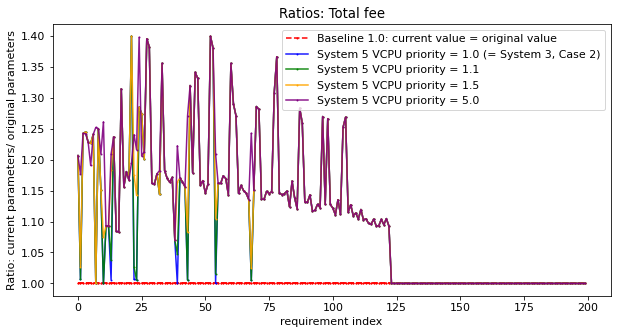

In [44]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_fee_ratio_array
r2 = v2_label_fee_ratio_array
r3 = v3_label_fee_ratio_array
r4 = v4_label_fee_ratio_array

plt.title('Ratios: Total fee')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1)

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value')
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 5 VCPU priority = 1.0 (= System 3, Case 2)')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='System 5 VCPU priority = 1.1')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='orange',label='System 5 VCPU priority = 1.5')
plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='purple',label='System 5 VCPU priority = 5.0')
'''
m1 = np.mean(v1_label_vcpu_ratio)
r1m = [m1]*len(x)
m2 = np.mean(v2_label_vcpu_ratio)
r2m = [m2]*len(x)
plt.plot(x, r1m, marker='1', markersize=1, alpha = 0.9, color='c',label='Triangular membership function')
plt.plot(x, r2m, marker='1', markersize=1, alpha = 0.9, color='m',label='Gaussion membership function')
print(m3)
print(m4)
'''
m1 = np.mean(r1)
m2 = np.mean(r2)
m3 = np.mean(r3)
m4 = np.mean(r4)

print(m1)
print(m4)

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_priority_fee.jpg')
plt.show()  # 显示折线图

1.8096432079208555
1.8708109935665822


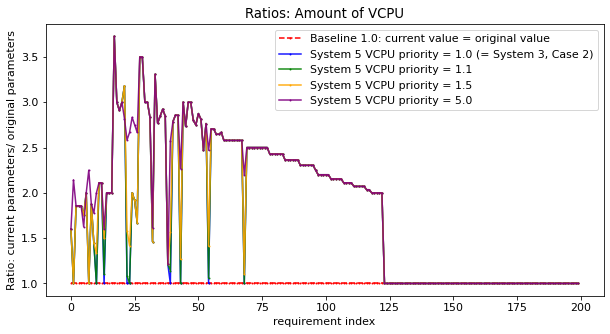

In [45]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_vcpu_ratio
r2 = v2_label_vcpu_ratio
r3 = v3_label_vcpu_ratio
r4 = v4_label_vcpu_ratio

plt.title('Ratios: Amount of VCPU')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value')
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 5 VCPU priority = 1.0 (= System 3, Case 2)')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='System 5 VCPU priority = 1.1')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='orange',label='System 5 VCPU priority = 1.5')
plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='purple',label='System 5 VCPU priority = 5.0')

m1 = np.mean(v1_label_vcpu_ratio)
m2 = np.mean(v2_label_vcpu_ratio)
m3 = np.mean(v3_label_vcpu_ratio)
m4 = np.mean(v4_label_vcpu_ratio)

print(m3)
print(m4)

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_priority_vcpu.jpg')
plt.show()  # 显示折线图

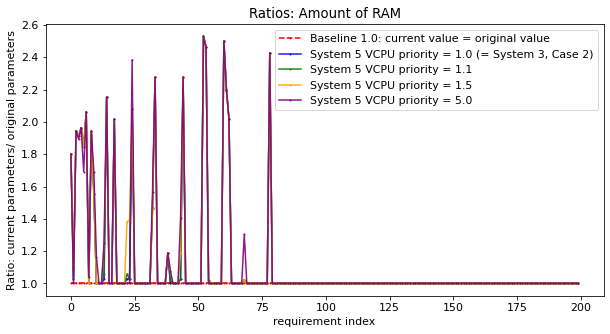

In [46]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_ram_ratio
r2 = v2_label_ram_ratio
r3 = v3_label_ram_ratio
r4 = v4_label_ram_ratio

plt.title('Ratios: Amount of RAM')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value')
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 5 VCPU priority = 1.0 (= System 3, Case 2)')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='System 5 VCPU priority = 1.1')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='orange',label='System 5 VCPU priority = 1.5')
plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='purple',label='System 5 VCPU priority = 5.0')

plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/diff_priority_ram.jpg')
plt.show()  # 显示折线图

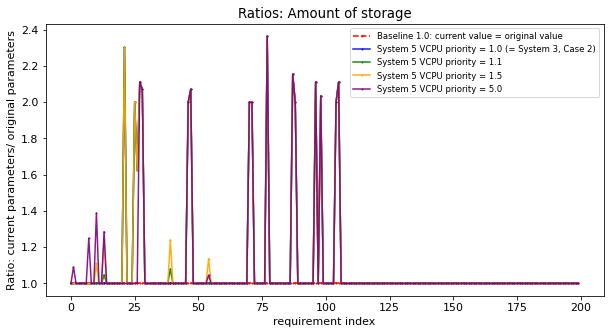

In [47]:
plt.figure(figsize=[10, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r1 = v1_label_storage_ratio
r2 = v2_label_storage_ratio
r3 = v3_label_storage_ratio
r4 = v4_label_storage_ratio

plt.title('Ratios: Amount of storage')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value')
plt.plot(x, r1, marker='o', markersize=1, alpha = 0.9, color='blue',label='System 5 VCPU priority = 1.0 (= System 3, Case 2)')
plt.plot(x, r2, marker='o', markersize=1, alpha = 0.9, color='green',label='System 5 VCPU priority = 1.1')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.9, color='orange',label='System 5 VCPU priority = 1.5')
plt.plot(x, r4, marker='o', markersize=1, alpha = 0.9, color='purple',label='System 5 VCPU priority = 5.0')
plt.legend(fontsize=8.5, loc='upper right')

plt.savefig('./pics/data_v1_deepNN/diff_priority_storage.jpg')
plt.show()  # 显示折线图

## ML Experiments

1.8096432079208555
1.912685208357849
2.0905436581996697
2.12823472822415
2.119237139182327


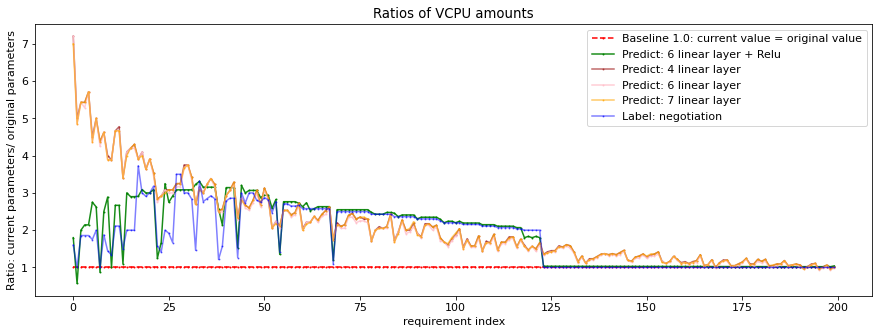

In [51]:
plt.figure(figsize=[15, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r3 = v3_label_vcpu_ratio
r30 = v3_predict_vcpu_ratio
r31 = v3_predict1_vcpu_ratio
r32 = v3_predict2_vcpu_ratio
r33 = v3_predict3_vcpu_ratio

plt.title('Ratios of VCPU amounts')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 

plt.plot(x, r30, marker='o', markersize=1, alpha = 0.9, color='green',label='Predict: 6 linear layer + Relu')
plt.plot(x, r32, marker='o', markersize=1, alpha = 0.7, color='brown',label='Predict: 4 linear layer')
plt.plot(x, r31, marker='o', markersize=1, alpha = 0.8, color='pink',label='Predict: 6 linear layer')

plt.plot(x, r33, marker='o', markersize=1, alpha = 0.6, color='orange',label='Predict: 7 linear layer')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.5, color='blue',label='Label: negotiation')

'''
123 647
m3 = np.mean(v3_predict_vcpu_ratio)
r3m = [m3]*len(x)
m4 = np.mean(v3_label_vcpu_ratio)
r4m = [m4]*len(x)
print(m3)
print(m4)

plt.plot(x, r3m, marker='1', markersize=1, alpha = 0.9, color='c',label='V3 ML vcpu average ratio_deepNN')
plt.plot(x, r4m, marker='1', markersize=1, alpha = 0.9, color='m',label='V3 Negotiation vcpu average ratio')

print(m3)
print(m4)
'''
m3 = np.mean(v3_label_vcpu_ratio)
m30 = np.mean(v3_predict_vcpu_ratio)
m31 = np.mean(v3_predict1_vcpu_ratio)
m32 = np.mean(v3_predict2_vcpu_ratio)
m33 = np.mean(v3_predict3_vcpu_ratio)
print(m3)
print(m30)
print(m31)
print(m32)
print(m33)
plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/v3_vcpu_Negotiation_ML_compare.jpg')
plt.show()  # 显示折线图

1.1152398900953633
1.1271834602013115
1.138715117702666
1.1361556615325181
1.1203857744852295


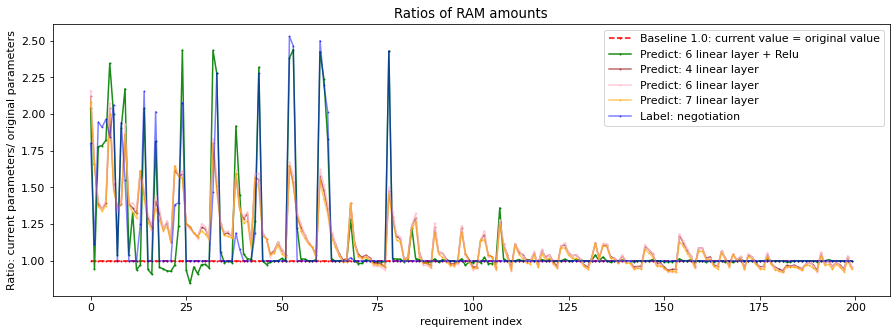

In [52]:
plt.figure(figsize=[15, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r3 = v3_label_ram_ratio
r30 = v3_predict_ram_ratio
r31 = v3_predict1_ram_ratio
r32 = v3_predict2_ram_ratio
r33 = v3_predict3_ram_ratio

plt.title('Ratios of RAM amounts')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 

plt.plot(x, r30, marker='o', markersize=1, alpha = 0.9, color='green',label='Predict: 6 linear layer + Relu')
plt.plot(x, r32, marker='o', markersize=1, alpha = 0.7, color='brown',label='Predict: 4 linear layer')
plt.plot(x, r31, marker='o', markersize=1, alpha = 0.8, color='pink',label='Predict: 6 linear layer')

plt.plot(x, r33, marker='o', markersize=1, alpha = 0.6, color='orange',label='Predict: 7 linear layer')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.5, color='blue',label='Label: negotiation')

'''
123 647
m3 = np.mean(v3_predict_ram_ratio)
r3m = [m3]*len(x)
m4 = np.mean(v3_label_ram_ratio)
r4m = [m4]*len(x)
print(m3)
print(m4)

plt.plot(x, r3m, marker='1', markersize=1, alpha = 0.9, color='c',label='V3 ML ram average ratio_deepNN')
plt.plot(x, r4m, marker='1', markersize=1, alpha = 0.9, color='m',label='V3 Negotiation ram average ratio')

print(m3)
print(m4)
'''
m3 = np.mean(v3_label_ram_ratio)
m30 = np.mean(v3_predict_ram_ratio)
m31 = np.mean(v3_predict1_ram_ratio)
m32 = np.mean(v3_predict2_ram_ratio)
m33 = np.mean(v3_predict3_ram_ratio)
print(m3)
print(m30)
print(m31)
print(m32)
print(m33)
plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/v3_ram_Negotiation_ML_compare.jpg')
plt.show()  # 显示折线图

1.0884153678197532
1.089653903639581
1.0847690921018236
1.107164012661423
1.0961858116236514


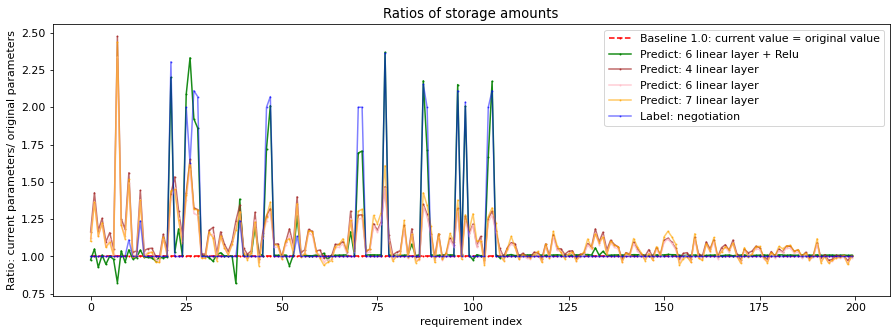

In [53]:
plt.figure(figsize=[15, 5])

x = list(df_x_test.index)
r0 = [1]*len(x)

r3 = v3_label_storage_ratio
r30 = v3_predict_storage_ratio
r31 = v3_predict1_storage_ratio
r32 = v3_predict2_storage_ratio
r33 = v3_predict3_storage_ratio

plt.title('Ratios of storage amounts')  # 折线图标题
plt.xlabel('requirement index')  # x轴标题
plt.ylabel('Ratio: current parameters/ original parameters')  # y轴标题

plt.plot(x, r0, c = 'r', marker='o',linestyle='dashed', markersize=1,label='Baseline 1.0: current value = original value') 

plt.plot(x, r30, marker='o', markersize=1, alpha = 0.9, color='green',label='Predict: 6 linear layer + Relu')
plt.plot(x, r32, marker='o', markersize=1, alpha = 0.7, color='brown',label='Predict: 4 linear layer')
plt.plot(x, r31, marker='o', markersize=1, alpha = 0.8, color='pink',label='Predict: 6 linear layer')

plt.plot(x, r33, marker='o', markersize=1, alpha = 0.6, color='orange',label='Predict: 7 linear layer')
plt.plot(x, r3, marker='o', markersize=1, alpha = 0.5, color='blue',label='Label: negotiation')

'''
123 647
m3 = np.mean(v3_predict_storage_ratio)
r3m = [m3]*len(x)
m4 = np.mean(v3_label_storage_ratio)
r4m = [m4]*len(x)
print(m3)
print(m4)

plt.plot(x, r3m, marker='1', markersize=1, alpha = 0.9, color='c',label='V3 ML storage average ratio_deepNN')
plt.plot(x, r4m, marker='1', markersize=1, alpha = 0.9, color='m',label='V3 Negotiation storage average ratio')

print(m3)
print(m4)
'''
m3 = np.mean(v3_label_storage_ratio)
m30 = np.mean(v3_predict_storage_ratio)
m31 = np.mean(v3_predict1_storage_ratio)
m32 = np.mean(v3_predict2_storage_ratio)
m33 = np.mean(v3_predict3_storage_ratio)
print(m3)
print(m30)
print(m31)
print(m32)
print(m33)
plt.legend(loc=1)

plt.savefig('./pics/data_v1_deepNN/v3_storage_Negotiation_ML_compare.jpg')
plt.show()  # 显示折线图